In [1]:
import os
import sys
import glob as glob
import numpy as np
import datetime
import cv2
import keras
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD
import tensorflow
from scipy.interpolate import spline
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
keras.__version__

'1.2.2'

In [3]:
tensorflow.__version__

'0.12.0'

In [4]:
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

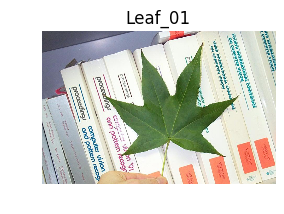

In [5]:
img = load_img('images/image_0027.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Leaf_01')
plt.show()

In [6]:
x = img_to_array(img)
x2 = x.reshape((1,) + x.shape)

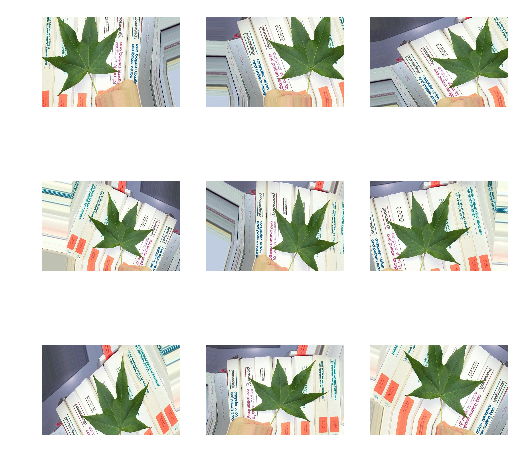

In [7]:
i = 0
fig = plt.figure(figsize = (6,6))
plt.title('Pre-processed')
for batch in datagen.flow(x2, batch_size = 1):
    i += 1
    if i > 9:
        break
    temp = batch.reshape(x.shape)
    plt.subplot(3, 3, i)
    plt.imshow(temp.astype('uint8'))
    plt.axis('off')
plt.show()

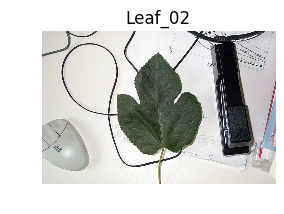

In [8]:
img = load_img('images/image_0110.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Leaf_02')
plt.show()

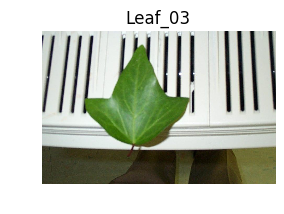

In [9]:
img = load_img('images/image_0153.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Leaf_03')
plt.show()

In [10]:
# default settings
img_width, img_height = 224, 224

train_dir = 'data/train'
validate_dir = 'data/validate'
nb_epochs = 20 
batch_size = 64
nb_classes = len(glob.glob(train_dir + '/*'))

In [11]:
# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_train_samples)

125


In [12]:
# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_validate_samples)

37


In [13]:
# data pre-processing for training
train_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [14]:
# data pre-processing for validation
validate_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [15]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 125 images belonging to 3 classes.


In [16]:
# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 37 images belonging to 3 classes.


In [17]:
# set up transfer learning on pre-trained ImageNet VGG19 model - remove fully connected layer and replace
# with softmax for classifying 3 classes
vgg19_model = VGG19(weights = 'imagenet', include_top = False)
x = vgg19_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
model = Model(input = vgg19_model.input, output = predictions)

In [18]:
# freeze all layers of the pre-trained model
for layer in vgg19_model.layers:
    layer.trainable = False

In [19]:
# compile the new model using a RMSProp optimizer
model.compile(optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [20]:
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history = model.fit_generator(
    train_generator,
    nb_epoch = nb_epochs,
    samples_per_epoch = nb_train_samples,
    validation_data = validate_generator,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')
print('Training time: %s' % (now() - t))

Epoch 1/20
125/125 [==============================] - 138s - loss: 2.4804 - acc: 0.3200 - val_loss: 2.0008 - val_acc: 0.3243
Epoch 2/20
125/125 [==============================] - 131s - loss: 1.6103 - acc: 0.3520 - val_loss: 1.1846 - val_acc: 0.3243
Epoch 3/20
125/125 [==============================] - 129s - loss: 0.9928 - acc: 0.5280 - val_loss: 0.9668 - val_acc: 0.3784
Epoch 4/20
125/125 [==============================] - 137s - loss: 0.9568 - acc: 0.4800 - val_loss: 0.9307 - val_acc: 0.4324
Epoch 5/20
125/125 [==============================] - 135s - loss: 0.8285 - acc: 0.5840 - val_loss: 0.8837 - val_acc: 0.6216
Epoch 6/20
125/125 [==============================] - 135s - loss: 0.8181 - acc: 0.6640 - val_loss: 0.8045 - val_acc: 0.6757
Epoch 7/20
125/125 [==============================] - 133s - loss: 0.7115 - acc: 0.7840 - val_loss: 0.7487 - val_acc: 0.7027
Epoch 8/20
125/125 [==============================] - 135s - loss: 0.6507 - acc: 0.8240 - val_loss: 0.6309 - val_acc: 0.9459


In [21]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.335126519203
Test Accuracy: 1.0


In [22]:
model.save('leaves_vgg19_model_tl.h5')

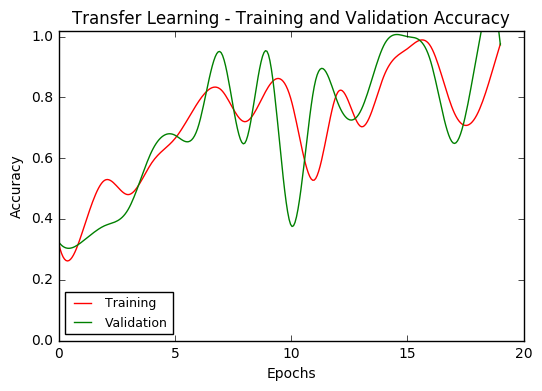

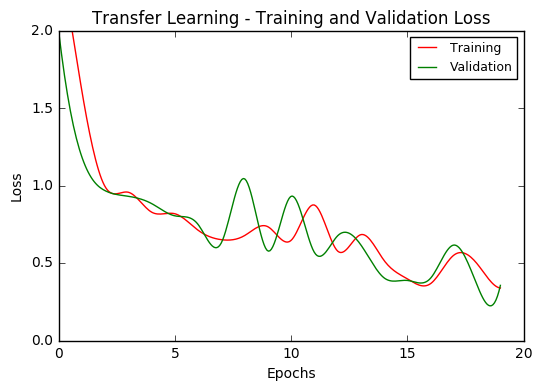

In [23]:
xfer_acc = transfer_learning_history.history['acc']
val_acc = transfer_learning_history.history['val_acc']
xfer_loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']
epochs = range(len(xfer_acc))

x = np.array(epochs)
y = np.array(xfer_acc)
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = spline(x, y, x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_acc)
x1_smooth = np.linspace(x1.min(), x1.max(), 300)
y1_smooth = spline(x1, y1, x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Accuracy')
plt.legend(loc = 'lower left', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1.02)

plt.figure()
x = np.array(epochs)
y = np.array(xfer_loss)
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = spline(x, y, x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_loss)
x1_smooth = np.linspace(x1.min(), x1.max(), 300)
y1_smooth = spline(x1, y1, x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Loss')
plt.legend(loc = 'upper right', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,max(y1))
plt.show()

In [24]:
validate_generator.total_batches_seen

231

In [25]:
predict_files = glob.glob("leaves_test/*.jpg")

In [26]:
im = cv2.imread(predict_files[0])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256, 256)).astype(np.float32)
im = np.expand_dims(im, axis = 0)/255

In [27]:
predict_files

['leaves_test\\Leaf_01_image_0021.jpg',
 'leaves_test\\Leaf_01_image_0025.jpg',
 'leaves_test\\Leaf_01_image_0040.jpg',
 'leaves_test\\Leaf_01_image_0051.jpg',
 'leaves_test\\Leaf_01_image_0058.jpg',
 'leaves_test\\Leaf_02_image_0102.jpg',
 'leaves_test\\Leaf_02_image_0104.jpg',
 'leaves_test\\Leaf_02_image_0113.jpg',
 'leaves_test\\Leaf_02_image_0119.jpg',
 'leaves_test\\Leaf_02_image_0124.jpg',
 'leaves_test\\Leaf_03_image_0161.jpg',
 'leaves_test\\Leaf_03_image_0164.jpg',
 'leaves_test\\Leaf_03_image_0173.jpg',
 'leaves_test\\Leaf_03_image_0180.jpg',
 'leaves_test\\Leaf_03_image_0184.jpg']

In [28]:
predictor, image_id = [], []
for i in predict_files:
    im = cv2.imread(i)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    outcome = [np.argmax(model.predict(im))]
    predictor.extend(list(outcome))
    image_id.extend([i.rsplit("\\")[-1]])

In [29]:
final = pd.DataFrame()
final["id"] = image_id
final["Leaf"] = predictor 
final.head(15)

,id,Leaf
0,Leaf_01_image_0021.jpg,0
1,Leaf_01_image_0025.jpg,0
2,Leaf_01_image_0040.jpg,0
3,Leaf_01_image_0051.jpg,0
4,Leaf_01_image_0058.jpg,0
5,Leaf_02_image_0102.jpg,1
6,Leaf_02_image_0104.jpg,1
7,Leaf_02_image_0113.jpg,1
8,Leaf_02_image_0119.jpg,1
9,Leaf_02_image_0124.jpg,1


In [30]:
classes = train_generator.class_indices
classes = {value : key for key, value in classes.items()}

In [31]:
final["Leaf"] = final["Leaf"].apply(lambda x: classes[x])
final.head(15)

,id,Leaf
0,Leaf_01_image_0021.jpg,Leaf_01
1,Leaf_01_image_0025.jpg,Leaf_01
2,Leaf_01_image_0040.jpg,Leaf_01
3,Leaf_01_image_0051.jpg,Leaf_01
4,Leaf_01_image_0058.jpg,Leaf_01
5,Leaf_02_image_0102.jpg,Leaf_02
6,Leaf_02_image_0104.jpg,Leaf_02
7,Leaf_02_image_0113.jpg,Leaf_02
8,Leaf_02_image_0119.jpg,Leaf_02
9,Leaf_02_image_0124.jpg,Leaf_02


In [32]:
for i, layer in enumerate(vgg19_model.layers):
   print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool


In [33]:
# Step 1 - Set up fine tuning on pre-trained ImageNet VGG19 model - train all layers
for layer in model.layers:
    layer.trainable = True
    
# Step 2 - Compile the revised model using SGD optimizer with a learing rate of 0.0001 and a momentum of 0.9
model.compile(optimizer = SGD(lr = 0.0001, momentum=0.9), 
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

# Step 3 - Fit the revised model, log the results and the training time
now = datetime.datetime.now
t = now()
fine_tuning_history = model.fit_generator(
    train_generator,
    nb_epoch = nb_epochs,
    samples_per_epoch = nb_train_samples,
    validation_data = validate_generator,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')
print('Training time: %s' % (now() - t))

Epoch 1/20
125/125 [==============================] - 316s - loss: 0.3083 - acc: 0.9520 - val_loss: 0.2969 - val_acc: 0.9730
Epoch 2/20
125/125 [==============================] - 315s - loss: 0.2831 - acc: 0.9760 - val_loss: 0.2976 - val_acc: 1.0000
Epoch 3/20
125/125 [==============================] - 313s - loss: 0.2645 - acc: 0.9920 - val_loss: 0.2946 - val_acc: 0.9459
Epoch 4/20
125/125 [==============================] - 313s - loss: 0.2537 - acc: 0.9840 - val_loss: 0.2492 - val_acc: 0.9730
Epoch 5/20
125/125 [==============================] - 317s - loss: 0.2173 - acc: 0.9920 - val_loss: 0.2827 - val_acc: 0.9459
Epoch 6/20
125/125 [==============================] - 305s - loss: 0.1815 - acc: 0.9920 - val_loss: 0.2033 - val_acc: 0.9730
Epoch 7/20
125/125 [==============================] - 304s - loss: 0.1561 - acc: 1.0000 - val_loss: 0.1992 - val_acc: 0.9730
Epoch 8/20
125/125 [==============================] - 305s - loss: 0.1559 - acc: 0.9920 - val_loss: 0.1228 - val_acc: 1.0000


In [34]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.0672046169639
Test Accuracy: 0.972972989082


In [35]:
model.save('leaves_vgg19_model_ft.h5')

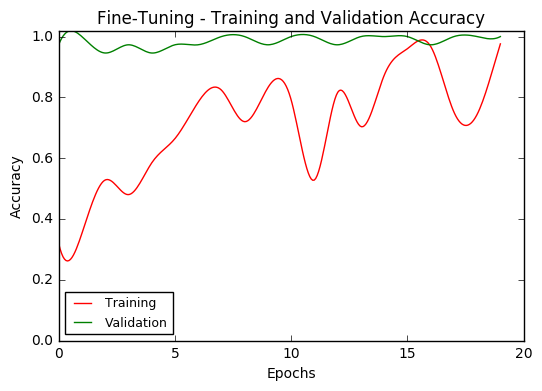

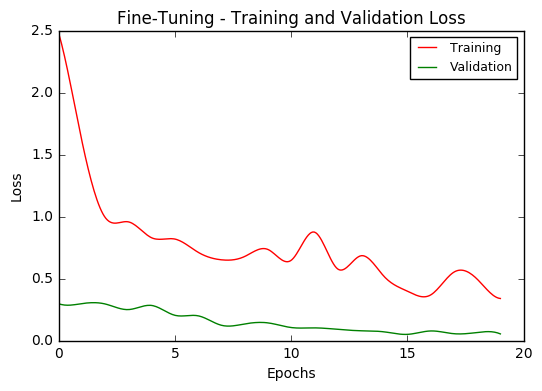

In [45]:
ft_acc = fine_tuning_history.history['acc']
val_acc = fine_tuning_history.history['val_acc']
ft_loss = fine_tuning_history.history['loss']
val_loss = fine_tuning_history.history['val_loss']
epochs = range(len(ft_acc))

x = np.array(epochs)
y = np.array(xfer_acc)
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = spline(x, y, x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_acc)
x1_smooth = np.linspace(x1.min(), x1.max(), 300)
y1_smooth = spline(x1, y1, x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Fine-Tuning - Training and Validation Accuracy')
plt.legend(loc = 'lower left', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1.02)

plt.figure()
x = np.array(epochs)
y = np.array(xfer_loss)
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = spline(x, y, x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_loss)
x1_smooth = np.linspace(x1.min(), x1.max(), 300)
y1_smooth = spline(x1, y1, x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Fine-Tuning - Training and Validation Loss')
plt.legend(loc = 'upper right', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,max(0, 2.5))
plt.show()

In [37]:
validate_generator.total_batches_seen

462

In [38]:
# predict unseen images
predict_files = glob.glob("leaves_test/*.jpg")

In [39]:
im = cv2.imread(predict_files[0])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256, 256)).astype(np.float32)
im = np.expand_dims(im, axis = 0)/255

In [40]:
predictor, image_id = [], []
for i in predict_files:
    im = cv2.imread(i)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    outcome = [np.argmax(model.predict(im))]
    predictor.extend(list(outcome))
    image_id.extend([i.rsplit("\\")[-1]])

In [41]:
final = pd.DataFrame()
final["id"] = image_id
final["Leaf"] = predictor 
final.head(15)

,id,Leaf
0,Leaf_01_image_0021.jpg,0
1,Leaf_01_image_0025.jpg,0
2,Leaf_01_image_0040.jpg,0
3,Leaf_01_image_0051.jpg,0
4,Leaf_01_image_0058.jpg,0
5,Leaf_02_image_0102.jpg,1
6,Leaf_02_image_0104.jpg,1
7,Leaf_02_image_0113.jpg,1
8,Leaf_02_image_0119.jpg,1
9,Leaf_02_image_0124.jpg,1


In [42]:
classes = train_generator.class_indices
classes = {value : key for key, value in classes.items()}

In [43]:
final["Leaf"] = final["Leaf"].apply(lambda x: classes[x])
final.head(15)

,id,Leaf
0,Leaf_01_image_0021.jpg,Leaf_01
1,Leaf_01_image_0025.jpg,Leaf_01
2,Leaf_01_image_0040.jpg,Leaf_01
3,Leaf_01_image_0051.jpg,Leaf_01
4,Leaf_01_image_0058.jpg,Leaf_01
5,Leaf_02_image_0102.jpg,Leaf_02
6,Leaf_02_image_0104.jpg,Leaf_02
7,Leaf_02_image_0113.jpg,Leaf_02
8,Leaf_02_image_0119.jpg,Leaf_02
9,Leaf_02_image_0124.jpg,Leaf_02
